In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prettytable import PrettyTable

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
def metrics_summarize(X, y, y_pred, estimator = False, split_cv = 5):
    """
    This function will take the predictable co-variables, the target and predicted y value
    to calculate the Coefficient of determination or R2.    
    """
    r2 = r2_score(y, y_pred) 
    
    if estimator != False:
        c_scores = cross_validate(estimator, X, y, cv=split_cv, scoring='r2', n_jobs=-1)
        r2_cv = c_scores['test_score'].mean()
        r2_std = c_scores['test_score'].std()
    else:
        r2_cv = '-'
        r2_std = '-'
    
    
    return {'R2':r2, 'R2_CV':r2_cv, 'R2_std':r2_std}

In [4]:
def metrics_summarize_mae(X, y, y_pred, estimator = False, split_cv = 5):
    """
    This function will take the predictable co-variables, the target and predicted y value
    to calculate the Coefficient of determination or R2.    
    """
    mae = mean_absolute_error(y, y_pred) 
    
    if estimator != False:
        c_scores = cross_validate(estimator, X, y, cv=split_cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        mae_cv = c_scores['test_score'].mean() * -1
        mae_std = c_scores['test_score'].std()
    else:
        mae_cv = '-'
        mae_std = '-'
    
    
    return {'MAE':mae, 'MAE_CV':mae_cv, 'MAE_std':mae_std}

In [5]:
def metrics_summarize_rmse(X, y, y_pred, estimator = False, split_cv = 5):
    """
    This function will take the predictable co-variables, the target and predicted y value
    to calculate the Coefficient of determination or R2.    
    """
    rmse = mean_squared_error(y, y_pred, squared=False) 
    
    if estimator != False:
        c_scores = cross_validate(estimator, X, y, cv=split_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        rmse_cv = c_scores['test_score'].mean() * -1
        rmse_std = c_scores['test_score'].std()
    else:
        rmse_cv = '-'
        rmse_std = '-'
    
    
    return {'RMSE':rmse, 'RMSE_CV':rmse_cv, 'RMSE_std':rmse_std}

In [6]:
def metrics_summarize_mape(X, y, y_pred, estimator = False, split_cv = 5):
    """
    This function will take the predictable co-variables, the target and predicted y value
    to calculate the Coefficient of determination or R2.    
    """
    mape = mean_absolute_percentage_error(y, y_pred) 
    
    if estimator != False:
        c_scores = cross_validate(estimator, X, y, cv=split_cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        mape_cv = c_scores['test_score'].mean() * -1
        mape_std = c_scores['test_score'].std()
    else:
        mape_cv = '-'
        mape_std = '-'
    
    
    return {'MAPE':mape, 'MAPE_CV':mape_cv, 'MAPE_std':mape_std}

In [7]:
def build_model(regressor, X, y, show_plots = None, ts = 0.3, s_cv = 5, feature_compare = "Steam Flow Rate"):
    """
    This function builds the model and returns the metrics used to analyze the test and train datasets.
    Aditionally, this function can graph a distribution plot between y_real vs y_predicted.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = 42)
    
    regressor.fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    train_summary = metrics_summarize(X_train, y_train, y_train_pred, regressor, split_cv = s_cv)
    test_summary = metrics_summarize(X_test, y_test, y_test_pred)
    
    #Graph
    if show_plots == True:
        plt.figure(figsize = (21,7))
                      
        ax0 = plt.subplot(1,3,1)
        ax0.scatter(y_test, y_test_pred, s = 1)
    
        lims = [
            np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
            np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
        ]
    
        ax0.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlabel('Efficiency (test)')
        plt.ylabel('Predicted Efficiency (test)')
        plt.title('Relation between Predicted Efficiency vs Real Efficiency')
        
        ax1 = plt.subplot(1,3,2)
        sns.histplot(y_train - y_train_pred, bins = 20, label = 'train', color = 'b', stat='density', kde=1)
        sns.histplot(y_test - y_test_pred, bins = 20, label = 'test', color = 'y', stat='density', kde=1)
        plt.xlabel('Errors')
        plt.ylabel('Density')
        plt.title(f'Errors Density ($y$ - $y_p$)')
        plt.legend()
        
        ax2 = plt.subplot(1,3,3)
        ax2.scatter(X_train[feature_compare], y_train, s = 1, alpha = 0.2)
        ax2.scatter(X_test[feature_compare], y_test_pred, label = regressor, c = 'r', s = 1, alpha = 0.1)
        plt.xlabel(feature_compare)
        plt.ylabel('Efficiency')
        plt.title(f'Efficiency vs {feature_compare} \nModel {regressor}')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    
    return {'train':train_summary, 'test':test_summary}

In [8]:
def results_comparation(dictionary, table_name):
    """
    This function prints the summarize of metrics for the trained models, saved in a dictionary
    """
    table = PrettyTable(['Model', 'R2 (Training)', 'R2 (Cross Validation)', '(+/-)', ' ', 'R2 (Test)'])
    
    for key in dictionary:
        rtrain_1 = dictionary[key]['train']['R2']
        rtrain_2 = dictionary[key]['train']['R2_CV']
        rtrain_3 = dictionary[key]['train']['R2_std']
        rtest_1 = dictionary[key]['test']['R2']
        
        table.add_row([key, '{:.5f}'.format(rtrain_1), '{:.5f}'.format(rtrain_2), '{:.5f}'.format(rtrain_3), ' ', '{:.5f}'.format(rtest_1)])      
        
    print(table.get_string(title=table_name))

In [9]:
def build_model_mae(regressor, X, y, ts = 0.3, s_cv = 5):
    """
    This function builds the model and returns the metrics used to analyze the test and train datasets.
    Aditionally, this function can graph a distribution plot between y_real vs y_predicted.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = 42)
    
    regressor.fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    train_summary = metrics_summarize_mae(X_train, y_train, y_train_pred, regressor, split_cv = s_cv)
    test_summary = metrics_summarize_mae(X_test, y_test, y_test_pred)
    
    return {'train':train_summary, 'test':test_summary}

In [10]:
def results_comparation_mae(dictionary, table_name):
    """
    This function prints the summarize of metrics for the trained models, saved in a dictionary
    """
    table = PrettyTable(['Model', 'MAE (Training)', 'MAE (Cross Validation)', '(+/-)', ' ', 'MAE (Test)'])
    
    for key in dictionary:
        rtrain_1 = dictionary[key]['train']['MAE']
        rtrain_2 = dictionary[key]['train']['MAE_CV']
        rtrain_3 = dictionary[key]['train']['MAE_std']
        rtest_1 = dictionary[key]['test']['MAE']
        
        table.add_row([key, '{:.5f}'.format(rtrain_1), '{:.5f}'.format(rtrain_2), '{:.5f}'.format(rtrain_3), ' ', '{:.5f}'.format(rtest_1)])      
        
    print(table.get_string(title=table_name))

In [11]:
def build_model_rmse(regressor, X, y, ts = 0.3, s_cv = 5):
    """
    This function builds the model and returns the metrics used to analyze the test and train datasets.
    Aditionally, this function can graph a distribution plot between y_real vs y_predicted.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = 42)
    
    regressor.fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    train_summary = metrics_summarize_rmse(X_train, y_train, y_train_pred, regressor, split_cv = s_cv)
    test_summary = metrics_summarize_rmse(X_test, y_test, y_test_pred)
    
    return {'train':train_summary, 'test':test_summary}

In [12]:
def results_comparation_rmse(dictionary, table_name):
    """
    This function prints the summarize of metrics for the trained models, saved in a dictionary
    """
    table = PrettyTable(['Model', 'RMSE (Training)', 'RMSE (Cross Validation)', '(+/-)', ' ', 'RMSE (Test)'])
    
    for key in dictionary:
        rtrain_1 = dictionary[key]['train']['RMSE']
        rtrain_2 = dictionary[key]['train']['RMSE_CV']
        rtrain_3 = dictionary[key]['train']['RMSE_std']
        rtest_1 = dictionary[key]['test']['RMSE']
        
        table.add_row([key, '{:.5f}'.format(rtrain_1), '{:.5f}'.format(rtrain_2), '{:.5f}'.format(rtrain_3), ' ', '{:.5f}'.format(rtest_1)])      
        
    print(table.get_string(title=table_name))

In [13]:
def build_model_mape(regressor, X, y, ts = 0.3, s_cv = 5):
    """
    This function builds the model and returns the metrics used to analyze the test and train datasets.
    Aditionally, this function can graph a distribution plot between y_real vs y_predicted.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state = 42)
    
    regressor.fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    train_summary = metrics_summarize_mape(X_train, y_train, y_train_pred, regressor, split_cv = s_cv)
    test_summary = metrics_summarize_mape(X_test, y_test, y_test_pred)
    
    return {'train':train_summary, 'test':test_summary}

In [14]:
def results_comparation_mape(dictionary, table_name):
    """
    This function prints the summarize of metrics for the trained models, saved in a dictionary
    """
    table = PrettyTable(['Model', 'MAPE (Training)', 'MAPE (Cross Validation)', '(+/-)', ' ', 'MAPE (Test)'])
    
    for key in dictionary:
        rtrain_1 = dictionary[key]['train']['MAPE']
        rtrain_2 = dictionary[key]['train']['MAPE_CV']
        rtrain_3 = dictionary[key]['train']['MAPE_std']
        rtest_1 = dictionary[key]['test']['MAPE']
        
        table.add_row([key, '{:.5f}'.format(rtrain_1), '{:.5f}'.format(rtrain_2), '{:.5f}'.format(rtrain_3), ' ', '{:.5f}'.format(rtest_1)])      
        
    print(table.get_string(title=table_name))

In [3]:
df = pd.read_csv("data/KNN_sept.csv", parse_dates=["Time"])
df_hourly = pd.read_csv("data/prueba_KNN_hourly.csv", parse_dates=["Time"])
df_daily = pd.read_csv("data/KNN_daily.csv", parse_dates=["Time"])

In [4]:
df.set_index("Time", inplace=True)
df_hourly.set_index("Time", inplace=True)
df_daily.set_index("Time", inplace=True)

In [5]:
features_out = ['Borra Flow Rate', 'Cisco Flow Rate', 'Saturated liquid enthalpy', 'Saturated vapor enthalpy', 'Saturation temperature', 'Steam Energy', 'Fuel Energy', 'Heat of Comb_GN', 'Burner_pct']

In [18]:
models_evaluation = dict()
models_evaluation_mae = dict()
models_evaluation_rmse = dict()
models_evaluation_mape = dict()

In [6]:
df_model = df.drop(features_out, axis=1)
hourly_model = df_hourly.drop(features_out + ["Fossile CO2", "Biomass CO2"], axis=1)
daily_model = df_daily.drop(features_out, axis=1)

In [20]:
X_min = df_model.drop(["Efficiency"], axis=1)
y_min = df_model["Efficiency"]

X_hour = hourly_model.drop(["Efficiency"], axis=1)
y_hour = hourly_model["Efficiency"]

X_day = daily_model.drop(["Efficiency"], axis=1)
y_day = daily_model["Efficiency"]

In [21]:
linear = LinearRegression()

models_evaluation['LR Minutely data'] = build_model(linear, X_min, y_min)
models_evaluation['LR Hourly data'] = build_model(linear, X_hour, y_hour)
models_evaluation['LR Daily data'] = build_model(linear, X_day, y_day)

models_evaluation_mae['LR Minutely data'] = build_model_mae(linear, X_min, y_min)
models_evaluation_mae['LR Hourly data'] = build_model_mae(linear, X_hour, y_hour)
models_evaluation_mae['LR Daily data'] = build_model_mae(linear, X_day, y_day)

models_evaluation_rmse['LR Minutely data'] = build_model_rmse(linear, X_min, y_min)
models_evaluation_rmse['LR Hourly data'] = build_model_rmse(linear, X_hour, y_hour)
models_evaluation_rmse['LR Daily data'] = build_model_rmse(linear, X_day, y_day)

models_evaluation_mape['LR Minutely data'] = build_model_mape(linear, X_min, y_min)
models_evaluation_mape['LR Hourly data'] = build_model_mape(linear, X_hour, y_hour)
models_evaluation_mape['LR Daily data'] = build_model_mape(linear, X_day, y_day)

In [22]:
results_comparation(models_evaluation, 'Table 1. Model evaluation prediction of Efficiency - R2')
results_comparation_mae(models_evaluation_mae, 'Table 1. Model evaluation prediction of Efficiency - MAE')
results_comparation_rmse(models_evaluation_rmse, 'Table 1. Model evaluation prediction of Efficiency - RMSE')
results_comparation_mape(models_evaluation_mape, 'Table 1. Model evaluation prediction of Efficiency - MAPE')

+------------------------------------------------------------------------------------+
|              Table 1. Model evaluation prediction of Efficiency - R2               |
+------------------+---------------+-----------------------+---------+---+-----------+
|      Model       | R2 (Training) | R2 (Cross Validation) |  (+/-)  |   | R2 (Test) |
+------------------+---------------+-----------------------+---------+---+-----------+
| LR Minutely data |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|  LR Hourly data  |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|  LR Daily data   |    0.97824    |        0.96318        | 0.02271 |   |  0.92448  |
+------------------+---------------+-----------------------+---------+---+-----------+
+---------------------------------------------------------------------------------------+
|                Table 1. Model evaluation prediction of Efficiency - MAE               |
+------------------+----------------+

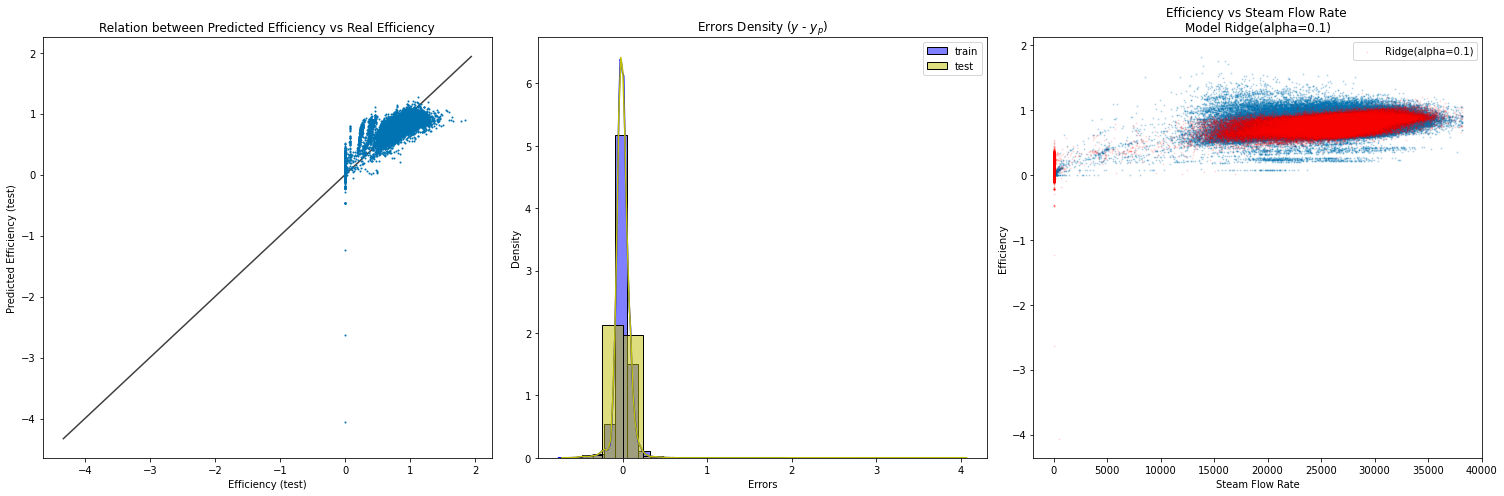

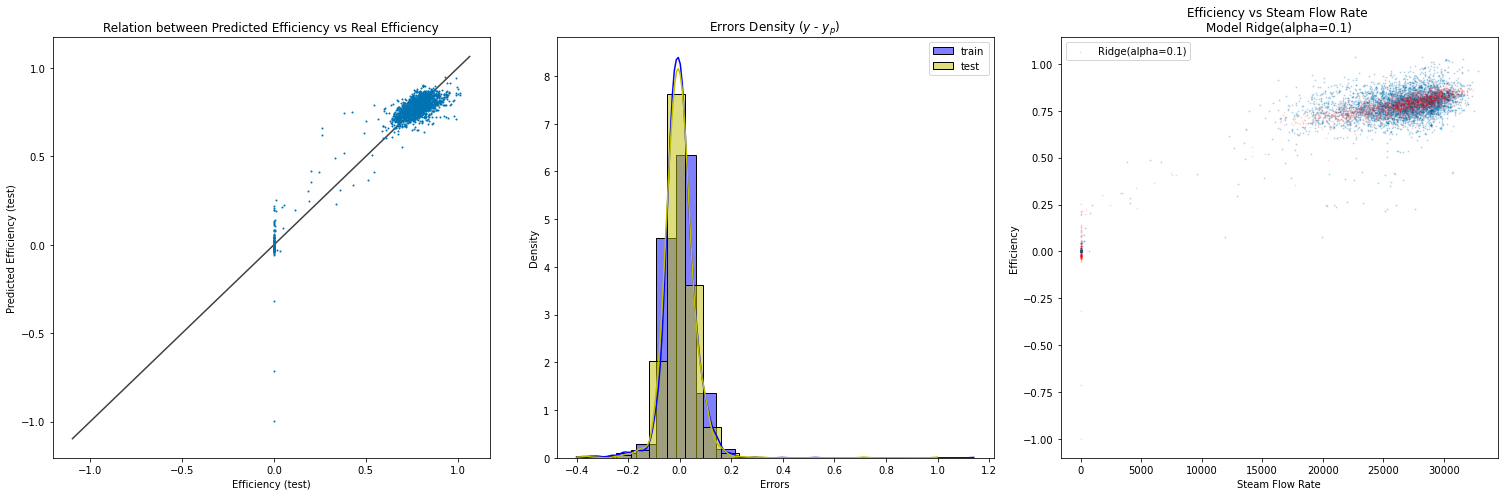

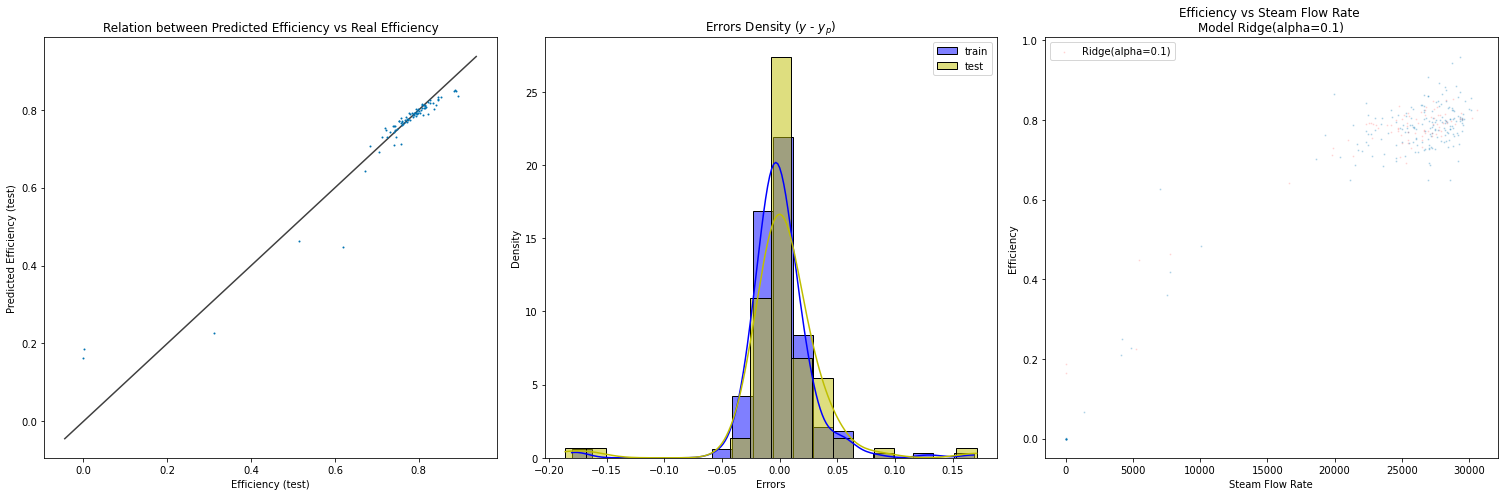

In [24]:
ridge = Ridge(alpha=0.1)

models_evaluation['Ridge LR Minutely data'] = build_model(ridge, X_min, y_min)
models_evaluation['Ridge LR Hourly data'] = build_model(ridge, X_hour, y_hour)
models_evaluation['Ridge LR Daily data'] = build_model(ridge, X_day, y_day)

In [25]:
results_comparation(models_evaluation, 'Table 1. Model evaluation prediction of Efficiency')

+------------------------------------------------------------------------------------------+
|                    Table 1. Model evaluation prediction of Efficiency                    |
+------------------------+---------------+-----------------------+---------+---+-----------+
|         Model          | R2 (Training) | R2 (Cross Validation) |  (+/-)  |   | R2 (Test) |
+------------------------+---------------+-----------------------+---------+---+-----------+
|    LR Minutely data    |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|     LR Hourly data     |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|     LR Daily data      |    0.97824    |        0.96318        | 0.02271 |   |  0.92448  |
| Ridge LR Minutely data |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|  Ridge LR Hourly data  |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|  Ridge LR Daily data   |    0.97824    |        0.96320        | 0.0

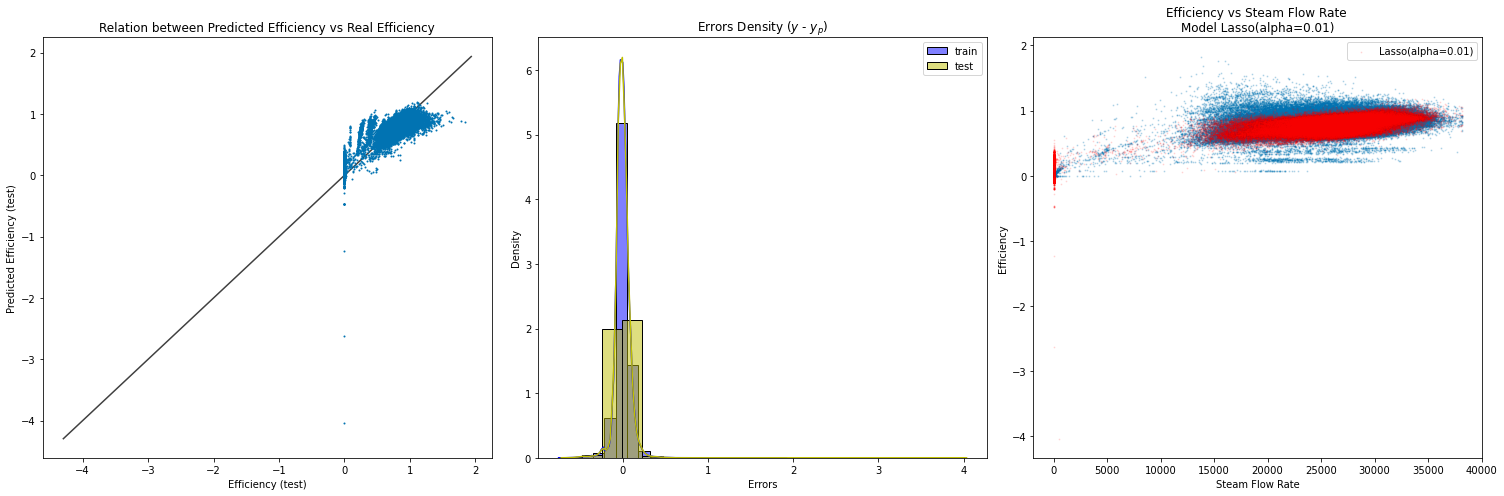

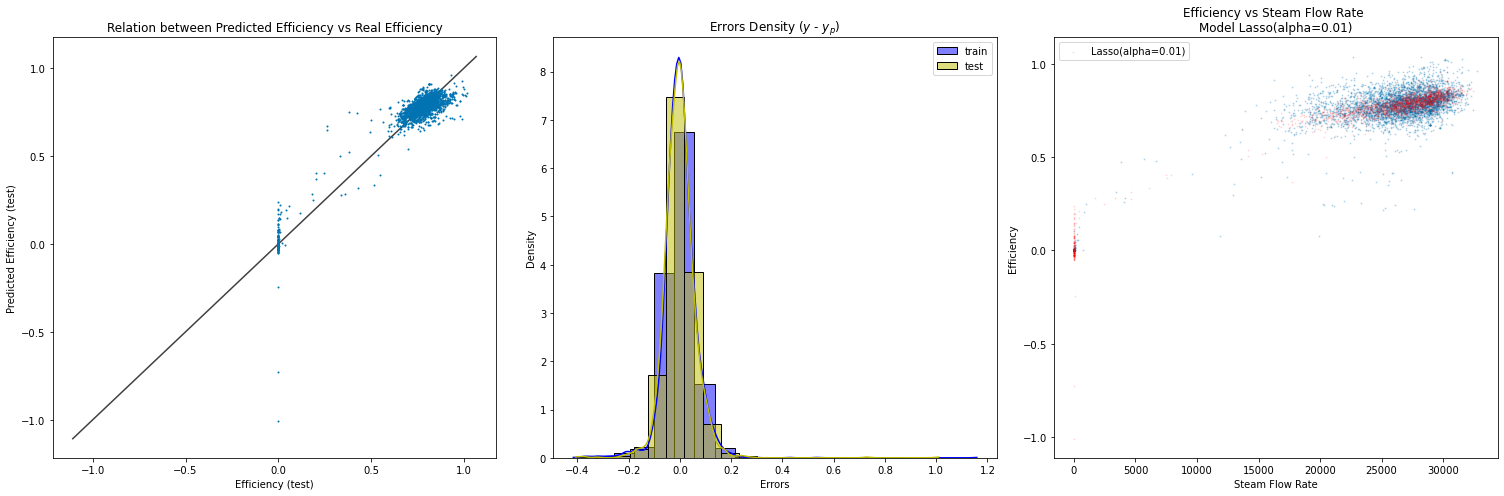

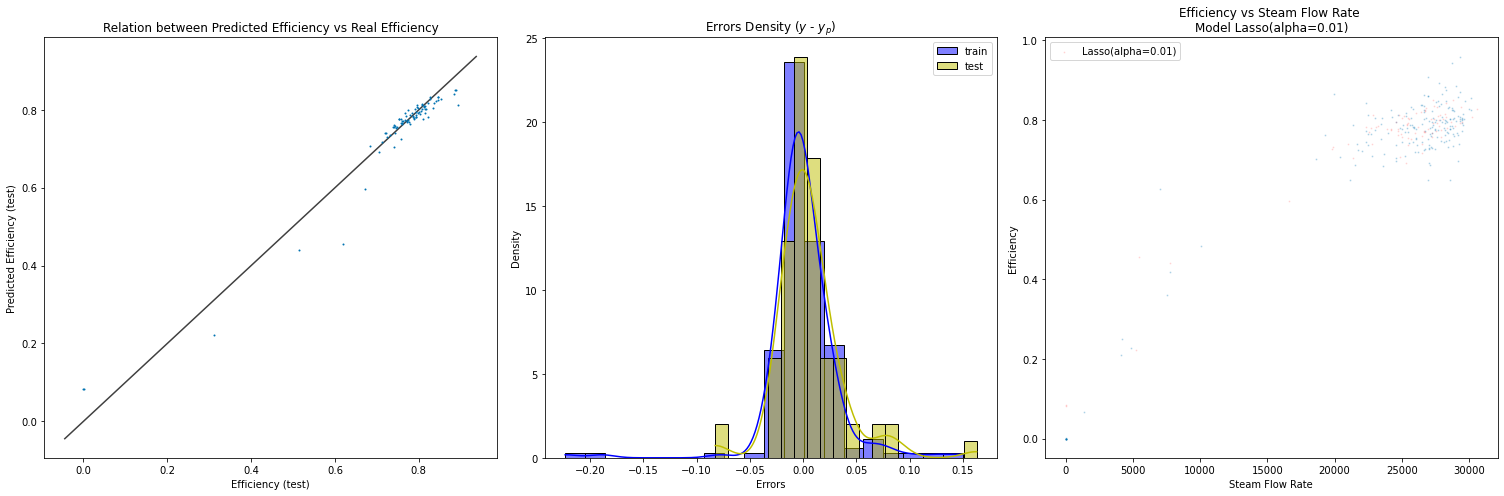

In [26]:
lasso = Lasso(alpha=0.01)

models_evaluation['Lasso LR Minutely data'] = build_model(lasso, X_min, y_min)
models_evaluation['Lasso LR Hourly data'] = build_model(lasso, X_hour, y_hour)
models_evaluation['Lasso LR Daily data'] = build_model(lasso, X_day, y_day)

In [27]:
results_comparation(models_evaluation, 'Table 1. Model evaluation prediction of Efficiency')

+------------------------------------------------------------------------------------------+
|                    Table 1. Model evaluation prediction of Efficiency                    |
+------------------------+---------------+-----------------------+---------+---+-----------+
|         Model          | R2 (Training) | R2 (Cross Validation) |  (+/-)  |   | R2 (Test) |
+------------------------+---------------+-----------------------+---------+---+-----------+
|    LR Minutely data    |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|     LR Hourly data     |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|     LR Daily data      |    0.97824    |        0.96318        | 0.02271 |   |  0.92448  |
| Ridge LR Minutely data |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|  Ridge LR Hourly data  |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|  Ridge LR Daily data   |    0.97824    |        0.96320        | 0.0

In [23]:
dt = DecisionTreeRegressor()

models_evaluation['DT Minutely data'] = build_model(dt, X_min, y_min)
models_evaluation['DT Hourly data'] = build_model(dt, X_hour, y_hour)
models_evaluation['DT Daily data'] = build_model(dt, X_day, y_day)

models_evaluation_mae['DT Minutely data'] = build_model_mae(dt, X_min, y_min)
models_evaluation_mae['DT Hourly data'] = build_model_mae(dt, X_hour, y_hour)
models_evaluation_mae['DT Daily data'] = build_model_mae(dt, X_day, y_day)

models_evaluation_rmse['DT Minutely data'] = build_model_rmse(dt, X_min, y_min)
models_evaluation_rmse['DT Hourly data'] = build_model_rmse(dt, X_hour, y_hour)
models_evaluation_rmse['DT Daily data'] = build_model_rmse(dt, X_day, y_day)

models_evaluation_mape['DT Minutely data'] = build_model_mape(dt, X_min, y_min)
models_evaluation_mape['DT Hourly data'] = build_model_mape(dt, X_hour, y_hour)
models_evaluation_mape['DT Daily data'] = build_model_mape(dt, X_day, y_day)

In [25]:
results_comparation(models_evaluation, 'Table 1. Model evaluation prediction of Efficiency - R2')
results_comparation_mae(models_evaluation_mae, 'Table 2. Model evaluation prediction of Efficiency - MAE')
results_comparation_rmse(models_evaluation_rmse, 'Table 3. Model evaluation prediction of Efficiency - RMSE')
results_comparation_mape(models_evaluation_mape, 'Table 4. Model evaluation prediction of Efficiency - MAPE')

+------------------------------------------------------------------------------------+
|              Table 1. Model evaluation prediction of Efficiency - R2               |
+------------------+---------------+-----------------------+---------+---+-----------+
|      Model       | R2 (Training) | R2 (Cross Validation) |  (+/-)  |   | R2 (Test) |
+------------------+---------------+-----------------------+---------+---+-----------+
| LR Minutely data |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|  LR Hourly data  |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|  LR Daily data   |    0.97824    |        0.96318        | 0.02271 |   |  0.92448  |
| DT Minutely data |    1.00000    |        0.99410        | 0.00028 |   |  0.99415  |
|  DT Hourly data  |    1.00000    |        0.97362        | 0.00160 |   |  0.97204  |
|  DT Daily data   |    1.00000    |        0.80427        | 0.17567 |   |  0.76234  |
+------------------+---------------+-------

In [23]:
rf = RandomForestRegressor()

models_evaluation['RF Minutely data'] = build_model(rf, X_min, y_min)
models_evaluation['RF Hourly data'] = build_model(rf, X_hour, y_hour)
models_evaluation['RF Daily data'] = build_model(rf, X_day, y_day)

models_evaluation_mae['RF Minutely data'] = build_model_mae(rf, X_min, y_min)
models_evaluation_mae['RF Hourly data'] = build_model_mae(rf, X_hour, y_hour)
models_evaluation_mae['RF Daily data'] = build_model_mae(rf, X_day, y_day)

models_evaluation_rmse['RF Minutely data'] = build_model_rmse(rf, X_min, y_min)
models_evaluation_rmse['RF Hourly data'] = build_model_rmse(rf, X_hour, y_hour)
models_evaluation_rmse['RF Daily data'] = build_model_rmse(rf, X_day, y_day)

models_evaluation_mape['RF Minutely data'] = build_model_mape(rf, X_min, y_min)
models_evaluation_mape['RF Hourly data'] = build_model_mape(rf, X_hour, y_hour)
models_evaluation_mape['RF Daily data'] = build_model_mape(rf, X_day, y_day)

In [25]:
results_comparation(models_evaluation, 'Table 1. Model evaluation prediction of Efficiency - R2')
results_comparation_mae(models_evaluation_mae, 'Table 2. Model evaluation prediction of Efficiency - MAE')
results_comparation_rmse(models_evaluation_rmse, 'Table 3. Model evaluation prediction of Efficiency - RMSE')
results_comparation_mape(models_evaluation_mape, 'Table 4. Model evaluation prediction of Efficiency - MAPE')

+------------------------------------------------------------------------------------+
|              Table 1. Model evaluation prediction of Efficiency - R2               |
+------------------+---------------+-----------------------+---------+---+-----------+
|      Model       | R2 (Training) | R2 (Cross Validation) |  (+/-)  |   | R2 (Test) |
+------------------+---------------+-----------------------+---------+---+-----------+
| LR Minutely data |    0.88431    |        0.88414        | 0.00126 |   |  0.87858  |
|  LR Hourly data  |    0.92225    |        0.90603        | 0.04068 |   |  0.91579  |
|  LR Daily data   |    0.97824    |        0.96318        | 0.02271 |   |  0.92448  |
| RF Minutely data |    0.99977    |        0.99820        | 0.00007 |   |  0.99829  |
|  RF Hourly data  |    0.99856    |        0.98888        | 0.00047 |   |  0.98990  |
|  RF Daily data   |    0.99251    |        0.92537        | 0.06512 |   |  0.89992  |
+------------------+---------------+-------

In [7]:
rf1 = RandomForestRegressor()
rf2 = RandomForestRegressor()

In [8]:
X_hour = hourly_model.drop(["Efficiency"], axis=1).values
y_hour = hourly_model["Efficiency"]

X_day = daily_model.drop(["Efficiency"], axis=1).values
y_day = daily_model["Efficiency"]

In [9]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_hour, y_hour, test_size = 0.3, random_state = 42)

X_train2, _, y_train2, _ = train_test_split(X_day, y_day, test_size = 0.3, random_state = 42)

In [10]:
%%time
rf1.fit(X_train1, y_train1)

Wall time: 3.54 s


RandomForestRegressor()

In [14]:
importances = rf1.feature_importances_

In [15]:
forest_importances = pd.Series(importances, index=hourly_model.drop(["Efficiency"], axis=1).columns)

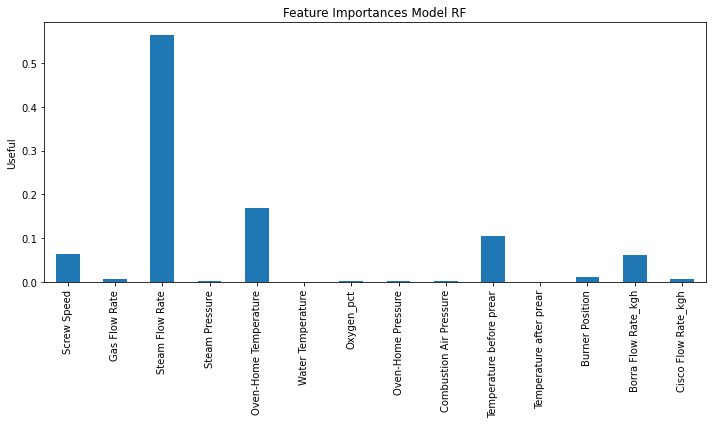

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances Model RF")
ax.set_ylabel("Useful")
fig.tight_layout()
fig.savefig("feature_importance.png")

In [14]:
%%time
rf2.fit(X_train2, y_train2)

Wall time: 137 ms


RandomForestRegressor()

In [11]:
from joblib import dump, load

dump(rf1, 'randomforest1.joblib')

['randomforest1.joblib']

In [12]:
print(X_test1[0])

[ 3.27800000e+01  8.73131711e+02  2.69449938e+04  1.70385075e+01
  7.53984704e+02  1.03151764e+02  1.26772638e+01 -8.07179539e+00
  1.04952468e+02  2.52172239e+02  1.86726633e+02  7.61923413e+01
  3.01606442e+03  8.42307850e+02]


In [13]:
y_test1[0]

0.7132693944430992

In [14]:
hourly_model.drop(["Efficiency"], axis=1).columns

Index(['Screw Speed', 'Gas Flow Rate', 'Steam Flow Rate', 'Steam Pressure',
       'Oven-Home Temperature', 'Water Temperature', 'Oxygen_pct',
       'Oven-Home Pressure', 'Combustion Air Pressure',
       'Temperature before prear', 'Temperature after prear',
       'Burner Position', 'Borra Flow Rate_kgh', 'Cisco Flow Rate_kgh'],
      dtype='object')

In [32]:
model = load('randomforest1.joblib') 

X_test = np.array([32, 900, 30000, 20.5, 820,
 103.15, 12.80, -8.07, 104.95, 252.17,
 186.72, 76.19, 2000, 500])

print(model.predict(X_test.reshape(1, -1))[0])

0.832076198049655


In [ ]:
gas_array = np.arange()
borra_array = np.arange()
cisco_array = np.arange()